# Basic tutorial for experimental API.

This tutorial demonstrates the usage of the new `Cows` object in the submodule `experimental`. The API of this class is not finalized yet, and may change without warning from version to version. The tutorial is a copy of the basic tutorial.

We will first cook up a toy model with a discriminant variable (invariant mass) and a control variable (decay time) and use it to generate some toy data.

Then we will use a fit to the invariant mass to obtain some component pdf estimates and use these to extract some weights which project out the signal only component in the decay time. 

We will demonstrate both the classic *sWeights* and the *Custom Ortogonal Weight functions* (COWs) method. See [arXiv:2112.04575](https://arxiv.org/abs/2112.04574) for more details.

In [17]:
from types import SimpleNamespace

# external requirements
import numpy as np
from scipy.stats import norm, expon
import matplotlib.pyplot as plt
from iminuit import Minuit
from iminuit.cost import ExtendedUnbinnedNLL

# from this package
from sweights.experimental import Cows
from sweights.testing import make_classic_toy # to generate a toy dataset
from sweights.util import plot_binned

## Toy model and toy data

We generate an m-distribution (for the discriminatory variable) and an independent t-distribution (the control variable). In particle physics, m is typically the invariant mass distribution of decay candidates, and t is the decay time distribution of these candidates. But any other two variables can be used, as long as they are independent in the pure signal and pure background.

In [18]:
# make a toy model
true_yield = SimpleNamespace()
true_yield.s = 1000
true_yield.b = 1000

# mass
mrange = (0, 1)
m_truth = SimpleNamespace()
m_truth.mu = 0.5
m_truth.sigma = 0.1
m_truth.slope = 1

# time
trange = (0, 1.5)
t_truth = SimpleNamespace()
t_truth.slope = 0.2
t_truth.mu = 0.1
t_truth.sigma = 1.0

toy = make_classic_toy(
    1,
    s=true_yield.s,
    b=true_yield.b,
    mrange=mrange,
    trange=trange,
    ms_mu=m_truth.mu,
    ms_sigma=m_truth.sigma,
    mb_mu=m_truth.slope,
    ts_mu=t_truth.slope,
    tb_mu=t_truth.mu,
    tb_sigma=t_truth.sigma,
)

## Make pdfs, plot ground truth and toy data 

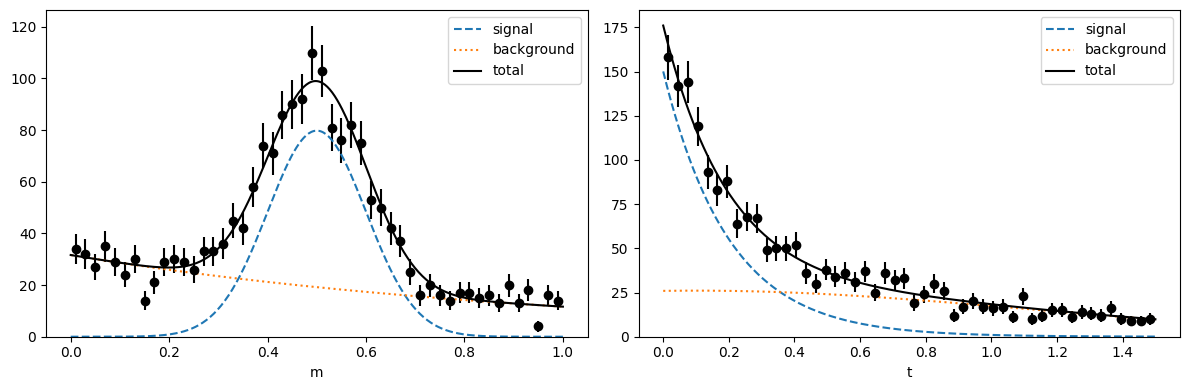

In [19]:
# m-density for fitting and plotting (not normalized)
def m_density(x, s, b, mu, sigma, slope):
    ds = norm(mu, sigma)
    snorm = np.diff(ds.cdf(mrange))

    db = expon(mrange[0], slope)
    bnorm = np.diff(db.cdf(mrange))

    return s / snorm * ds.pdf(x) + b / bnorm * db.pdf(x)


# t-density for fitting and plotting (not normalized)
def t_density(x, s, b, slope, mu, sigma):

    ds = expon(trange[0], slope)
    snorm = np.diff(ds.cdf(trange))

    db = norm(mu, sigma)
    bnorm = np.diff(db.cdf(trange))

    return s / snorm * ds.pdf(x) + b / bnorm * db.pdf(x)


def plot(toy, bins=50, npoint=400, draw_pdf=True):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    plt.sca(ax[0])
    plot_binned(toy[0], bins=bins, range=mrange, color="k")
    plt.sca(ax[1])
    plot_binned(toy[1], bins=bins, range=trange, color="k")

    if draw_pdf:
        m = np.linspace(*mrange, npoint)
        mnorm = (mrange[1] - mrange[0]) / bins

        par = m_truth.mu, m_truth.sigma, m_truth.slope
        s = m_density(m, true_yield.s, 0, *par)
        b = m_density(m, 0, true_yield.b, *par)
        p = s + b

        ax[0].plot(m, mnorm * s, "C0--", label="signal")
        ax[0].plot(m, mnorm * b, "C1:", label="background")
        ax[0].plot(m, mnorm * p, "k-", label="total")

        t = np.linspace(*trange, npoint)
        tnorm = (trange[1] - trange[0]) / bins

        par = t_truth.slope, t_truth.mu, t_truth.sigma
        s = t_density(t, true_yield.s, 0, *par)
        b = t_density(t, 0, true_yield.b, *par)
        p = s + b

        ax[1].plot(t, tnorm * s, "C0--", label="signal")
        ax[1].plot(t, tnorm * b, "C1:", label="background")
        ax[1].plot(t, tnorm * p, "k-", label="total")

    ax[0].set_xlabel("m")
    ax[0].set_ylim(bottom=0)
    ax[0].legend()

    ax[1].set_xlabel("t")
    ax[1].set_ylim(bottom=0)
    ax[1].legend()

    fig.tight_layout()

plot(toy)

## Fully automated computation

You can compute sWeights fully automatically with the `Cows`. You only need to provide parametric models of the signal and background pdfs, and the sample in the m-variable. The `Cows` class will fit these pdfs to get their shapes and yields, and then construct the weights.

To make the fit succeed you either need good starting values for the parameters or reasonable bounds for each parameter. Otherwise, the fit will fail. Parameter bounds are specified with a dictionary. An error is emitted if the fit fails, and a warning is emitted if the goodness-of-fit test fails. Either way, it is recommended to plot the normalizing function `norm`, which is the total pdf constructed from the signal and background pdfs and should match the data density, to check that the fit is looking ok.

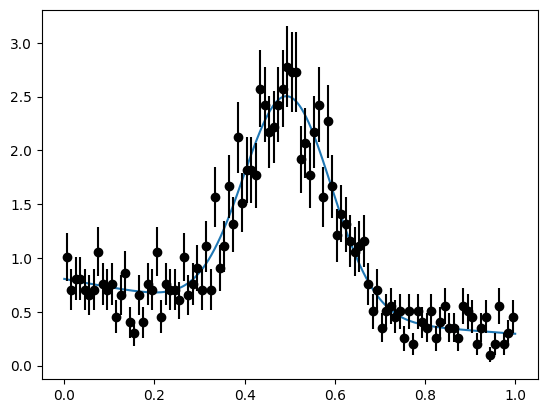

In [20]:
def norm_par(x, mu, sigma):
    d = norm(mu, sigma)
    return d.pdf(x) / np.diff(d.cdf(mrange))


def expon_par(x, slope):
    d = expon(0, slope)
    return d.pdf(x) / np.diff(d.cdf(mrange))


cows0 = Cows(
    toy[0],
    norm_par,
    expon_par,
    bounds={
        norm_par: {"mu": (0, 1), "sigma": (1e-3, 1)},
        expon_par: {"slope": (1e-3, 1)},
    },
    # you can optionally also pass starting values
    # starts={
    #   norm_par: {"mu": 0.4, "sigma": 0.2},
    #   expon_par: {"slope": 0.2}
    # }
)

mp = np.linspace(*mrange, 1000)
plt.plot(mp, cows0.norm(mp))
plot_binned(toy[0], density=True, color="k");

## Fit toy data in the m-variable

If the fully automatic mode does not work for you, or if you want to have full control over the fit (for example, to accelerate it, or because you have a special case like weighted events), you should fit the shapes of the component pdfs manually.

We show next how to do that with `iminuit`. We use an extended unbinned maximum-likelihood fit here, but an extended binned maximum-likelihood fit would work as well, and so would an ordinary fit instead of an extended fit. The extended fits are easier to set up, however. Note that a binned fit can be much faster.

Again, you need to specify limits (bounds) to avoid stepping into parameter space where the pdf is not defined.

In [21]:
# m-model for an extended maximum-likelihood fit, must return...
# - integral as first argument
# - density as second argument
# see iminuit documentation for more information
def m_model(x, s, b, mu, sigma, slope):
    return (s + b, m_density(x, s, b, mu, sigma, slope))


mi = Minuit(
    ExtendedUnbinnedNLL(toy[0], m_model),
    s=true_yield.s,
    b=true_yield.b,
    mu=m_truth.mu,
    sigma=m_truth.sigma,
    slope=m_truth.slope,
)
mi.limits["s", "b", "sigma", "slope"] = (0, None)
mi.limits["mu"] = mrange

mi.migrad()
mi.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -2.696e+04                 │              Nfcn = 139              │
│ EDM = 3.62e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s     │    960    │    50     │            │            │    0    │         │       │
│ 1 │ b     │  1.02e3   │  0.05e3   │            │            │    0    │         │       │
│ 2 │ mu    │   0.494   │   0.005   │            │            │    0    │    1    │       │
│ 3 │ sigma │   0.097   │   0.004   │            │            │    0    │         │       │
│ 4 │ slope │   1.14    │   0.16    │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬────────────────────────────────────────────────────────┐
│       │          s          b         mu      sigma      slope │
├───────┼────────────────────────────────────────────────────────┤
│     s │   2.13e+03     -1.2e3 -12.238e-3  91.503e-3     -1.038 │
│     b │     -1.2e3   2.18e+03  12.238e-3 -91.512e-3      1.038 │
│    mu │ -12.238e-3  12.238e-3   2.06e-05  -0.002e-3  -0.155e-3 │
│ sigma │  91.503e-3 -91.512e-3  -0.002e-3   1.87e-05  -0.070e-3 │
│ slope │     -1.038      1.038  -0.155e-3  -0.070e-3     0.0244 │
└───────┴────────────────────────────────────────────────────────┘

From the fit result, we create the fixed estimated pdfs of the signal and background component, respectively.

In [22]:
def spdf(m):
    return norm_par(m, *mi.values["mu", "sigma"])


def bpdf(m):
    return expon_par(m, mi.values["slope"])


In the COWs computation, component pdfs are divided by the normalizing function $I(m)$. This function is arbitrary, but there is an optimal choice, which minimizes the variance of the weights. In case of factorizing signal and background PDFs, the optimal choice is $I(m) \propto g(m)$, where $g(m)$ is the estimated total density of in the discriminant variable m.  This choice together with the summation method to compute the W matrix gives classic sWeights. A solution close to optimal is to replace $g(m)$ with a histogram, with the advantage that $g(m)$ does not have to be explicitly constructed.

`Cows` class accepts a great variety of inputs and tries to use the best computation method given the inputs. For example, the summation method can only be used if the sample in the m-variable is passed as input. Otherwise, the integration method is used. The normalizing function $I(m)$ can be computed by the `Cows` class as before, explicitly provided as a function or histogram.

In [23]:
# unity (not optimal, but simple):
def norm_unit(x):
    return np.ones_like(x) / (mrange[1] - mrange[0])


# classic sWeights:
def norm_opt(m):
    return m_density(m, *mi.values) / (mi.values["s"] + mi.values["b"])


# histogram:
norm_hist = np.histogram(toy[0], bins=20, range=mrange)

# cows1 and 2 use the unit normalization function
cows1 = Cows(toy[0], spdf, bpdf, norm_unit)
cows2 = Cows(None, spdf, bpdf, norm_unit, range=mrange)
# cows3 is equivalent to classic sWeights
cows3 = Cows(toy[0], spdf, bpdf, norm_opt, summation=True)
# cows 4 and 5 use a histogram
cows4 = Cows(toy[0], spdf, bpdf, norm_hist)
cows5 = Cows(None, spdf, bpdf, norm_hist)
# cows6 is again equivalent to classic sWeights, var_opt is computed internally,
# component yields are computed from the sample via fitting
cows6 = Cows(toy[0], spdf, bpdf)
# cows7 is equivalent to classic sWeights, var_opt is computed internally from
# the given component yields
cows7 = Cows(toy[0], spdf, bpdf, yields=mi.values["s", "b"])

/Users/hdembinski/Extern/sweights/src/sweights/experimental.py:126: CowsWarning: providing a sample and an external function with norm disables summation, override this with summation=True
  warnings.warn(


## Comparison of COWs

We first compare the weight distributions.

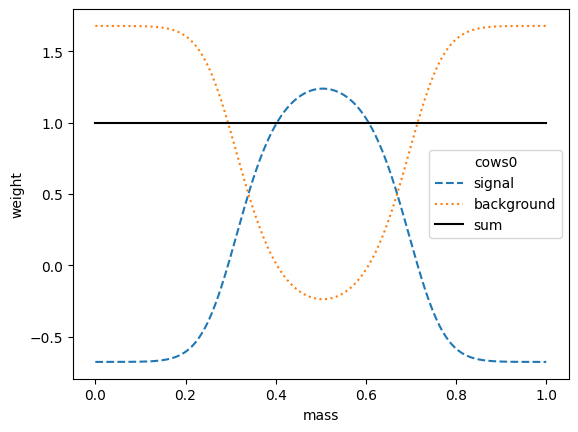

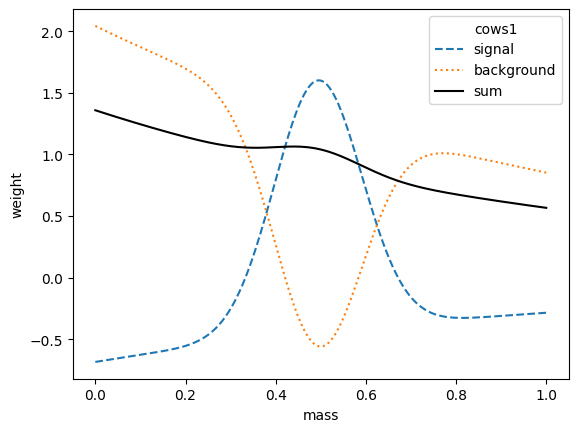

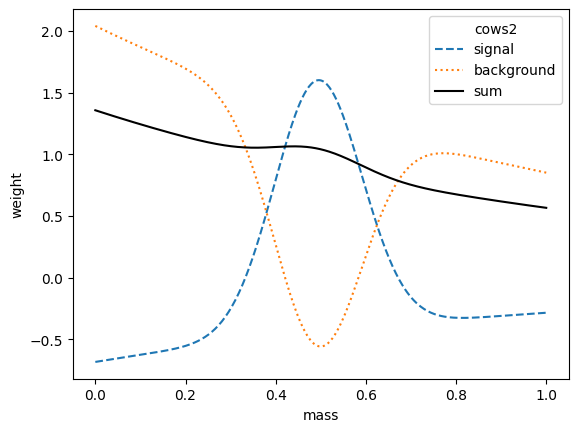

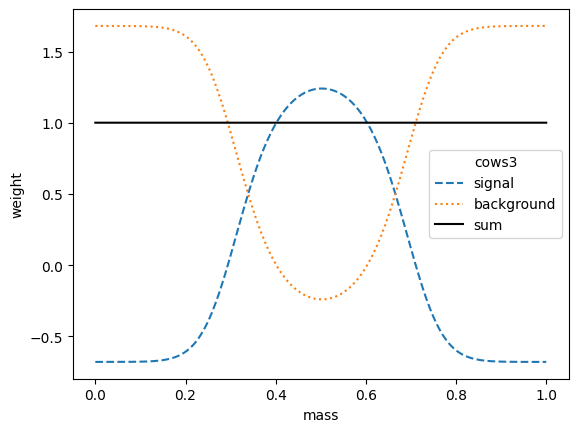

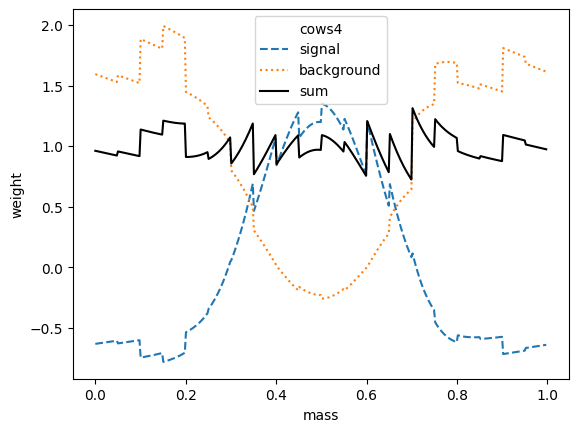

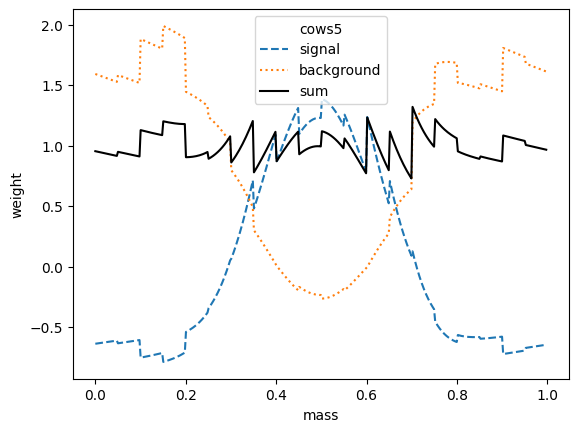

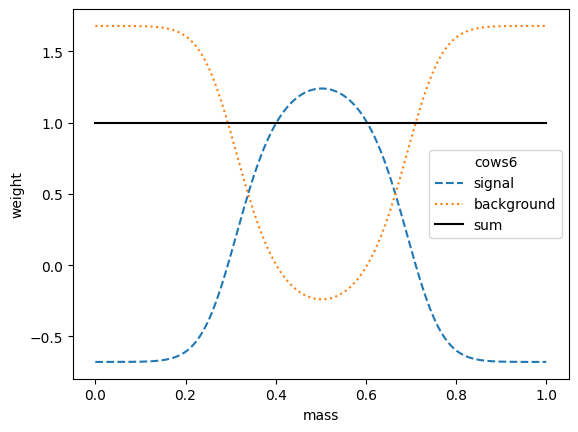

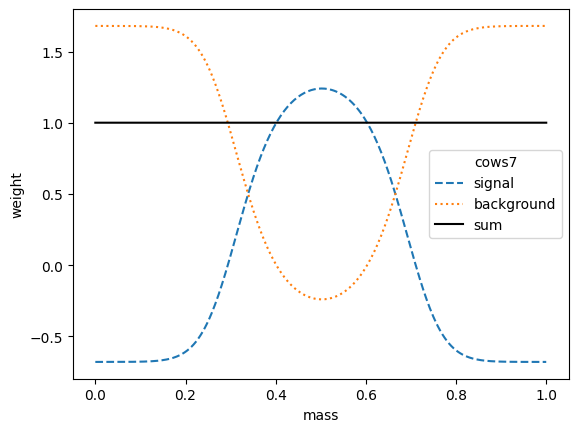

In [24]:
for i, weighter in enumerate([cows0, cows1, cows2, cows3, cows4, cows5, cows6, cows7]):
    x = np.linspace(*mrange, 400)
    swp = weighter(x, 0)
    bwp = weighter(x, 1)

    plt.figure()
    plt.plot(x, swp, "C0--", label="signal")
    plt.plot(x, bwp, "C1:", label="background")
    plt.plot(x, swp + bwp, "k-", label="sum")
    plt.xlabel("mass")
    plt.ylabel("weight")
    plt.legend(title=f"cows{i}")

All variants extract the signal in the control variable well.

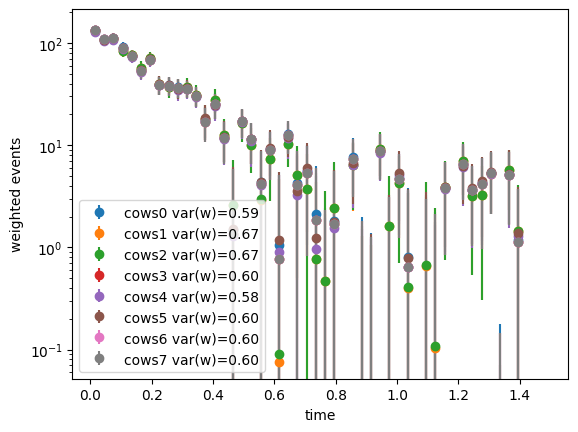

In [31]:
bins = 50
t = np.linspace(*trange, 400)

for i, weighter in enumerate([cows0, cows1, cows2, cows3, cows4, cows5, cows6, cows7]):
    w = weighter(toy[0])
    color = f"C{i}"
    plot_binned(
        toy[1],
        bins=bins,
        range=trange,
        weights=weighter(toy[0]),
        label=f"cows{i} var(w)={np.var(w):.2f}",
        color=color,
    )

plt.legend()
plt.xlabel("time")
plt.ylabel("weighted events")
plt.semilogy();

The variance of the weights should be as small as possible. Ignoring the small variations in the second digit, we find that the variances for all variants are equivalent, except when the unity normalizing function is used, which performs worse.